In [1]:
import pandas as pd

In [2]:
df=pd.read_csv("data_4.csv")

In [3]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [4]:
df.columns

Index(['lead_source', 'industry', 'number_of_courses_viewed', 'annual_income',
       'employment_status', 'location', 'interaction_count', 'lead_score',
       'converted'],
      dtype='object')

In [5]:
df.dtypes

,0
lead_source,object
industry,object
number_of_courses_viewed,int64
annual_income,float64
employment_status,object
location,object
interaction_count,int64
lead_score,float64
converted,int64


In [6]:
categorical_columns = ['lead_source', 'industry', 'employment_status', 'location']
df[categorical_columns] = df[categorical_columns].fillna('NA')

# For numerical columns, replace missing values with 0.0
numerical_columns = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']
df[numerical_columns] = df[numerical_columns].fillna(0.0)

In [10]:

# Step 4: Split the data into train, validation, and test (using numpy)
# Convert the DataFrame to a NumPy array
df_values = df.values

# Shuffle the data
np.random.seed(1)
np.random.shuffle(df_values)

# Calculate the number of samples for each dataset
n_samples = df_values.shape[0]
train_size = int(0.6 * n_samples)
validation_size = int(0.2 * n_samples)

# Split the data
train_data = df_values[:train_size]
validation_data = df_values[train_size:train_size + validation_size]
test_data = df_values[train_size + validation_size:]

# Convert back to DataFrames for easy handling
train_df = pd.DataFrame(train_data, columns=df.columns)
validation_df = pd.DataFrame(validation_data, columns=df.columns)
test_df = pd.DataFrame(test_data, columns=df.columns)

# Separate features and target for training, validation, and testing
X_train = train_df.drop('converted', axis=1)
y_train = train_df['converted']
X_validation = validation_df.drop('converted', axis=1)
y_validation = validation_df['converted']
X_test = test_df.drop('converted', axis=1)
y_test = test_df['converted']

In [13]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# Step 1: Define numerical columns for evaluation
numerical_columns = ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']

# Step 2: Ensure that the target variable (y_train) is binary
print("Target variable unique values:", np.unique(y_train))  # Check if y_train contains only 0s and 1s

# Step 3: Initialize a dictionary to store AUC values
auc_scores = {}

# Step 4: Compute AUC for each numerical variable
for col in numerical_columns:
    # Ensure the feature is numeric
    print(f"Checking column '{col}': {X_train[col].dtype}")

    auc = roc_auc_score(y_train, X_train[col])  # y_train is the target and X_train[col] is the feature
    auc_scores[col] = auc

    # Step 5: If AUC < 0.5, negate the variable (invert the direction)
    if auc < 0.5:
        print(f"AUC for {col} is less than 0.5, inverting the variable.")
        X_train[col] = -X_train[col]  # Invert the variable

# Step 6: Print the AUC scores for each numerical variable
print("\nAUC Scores for each numerical feature:")
for col, auc in auc_scores.items():
    print(f"{col}: {auc:.4f}")

# Step 7: Identify the variable with the highest AUC
best_feature = max(auc_scores, key=auc_scores.get)
print(f"\nThe numerical variable with the highest AUC is: {best_feature}")

Target variable unique values: [0 1]
Checking column 'lead_score': object


ValueError: unknown format is not supported

In [14]:
def compute_auc(df, numerical_columns, ground_truth):
    auc_results = {}
    for col in numerical_columns:
        # Drop rows with missing values in the feature or ground truth
        df_clean = df.dropna(subset=[col, ground_truth])

        # Compute AUC
        auc = roc_auc_score(df_clean[ground_truth], df_clean[col])

        # If AUC < 0.5, negate the feature
        if auc < 0.5:
            auc = roc_auc_score(df_clean[ground_truth], -df_clean[col])
            col = f'-{col}'  # Mark that the feature was negated

        auc_results[col] = auc

    return auc_results

# Compute AUC for the given features
auc_scores = compute_auc(df, numerical_columns, 'converted')

In [15]:
auc_scores

{'lead_score': np.float64(0.6148050428003213),
 'number_of_courses_viewed': np.float64(0.7608270430582144),
 'interaction_count': np.float64(0.7223206403681919),
 'annual_income': np.float64(0.5426406260848865)}

In [16]:
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Categorical columns to be one-hot encoded
categorical_columns = ['lead_source', 'industry', 'employment_status', 'location']
numerical_columns = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']

# Create the feature set as dictionaries
features = df[categorical_columns + numerical_columns].to_dict(orient='records')

# Apply one-hot encoding with DictVectorizer
dv = DictVectorizer(sparse=False)
X = dv.fit_transform(features)

# Prepare target variable
y = df['converted']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train logistic regression model
model = LogisticRegression(solver='liblinear')  # Use liblinear for small datasets
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# If you want to see the model coefficients:
print("\nModel Coefficients:")
print(pd.DataFrame(model.coef_, columns=dv.get_feature_names_out()))

Accuracy: 0.7372

Model Coefficients:
   annual_income  employment_status=NA  employment_status=employed  \
0      -0.000018             -0.008855                    0.028793   

   employment_status=self_employed  employment_status=student  \
0                         0.002023                   0.008257   

   employment_status=unemployed  industry=NA  industry=education  \
0                     -0.104672     -0.02251            0.048785   

   industry=finance  industry=healthcare  ...  lead_source=social_media  \
0         -0.024949              -0.0166  ...                 -0.021913   

   location=NA  location=africa  location=asia  location=australia  \
0     0.004364        -0.013064      -0.016335           -0.009023   

   location=europe  location=middle_east  location=north_america  \
0        -0.000773              0.000323               -0.020696   

   location=south_america  number_of_courses_viewed  
0                -0.01925                   0.44989  

[1 rows x 31 co

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Get predicted probabilities from the model
y_prob = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

# Lists to store precision, recall, and thresholds
precisions = []
recalls = []
thresholds = np.arange(0.0, 1.01, 0.01)

# Calculate precision and recall for each threshold
for threshold in thresholds:
    # Convert probabilities to binary predictions based on the threshold
    y_pred_threshold = (y_prob >= threshold).astype(int)

    # Compute precision and recall
    precision, recall, _ = precision_recall_curve(y_test, y_prob)

    # Store precision and recall at the given threshold
    precisions.append(precision[np.where(thresholds == threshold)[0][0]])
    recalls.append(recall[np.where(thresholds == threshold)[0][0]])

# Convert precision and recall to numpy arrays for easier plotting
precisions = np.array(precisions)
recalls = np.array(recalls)

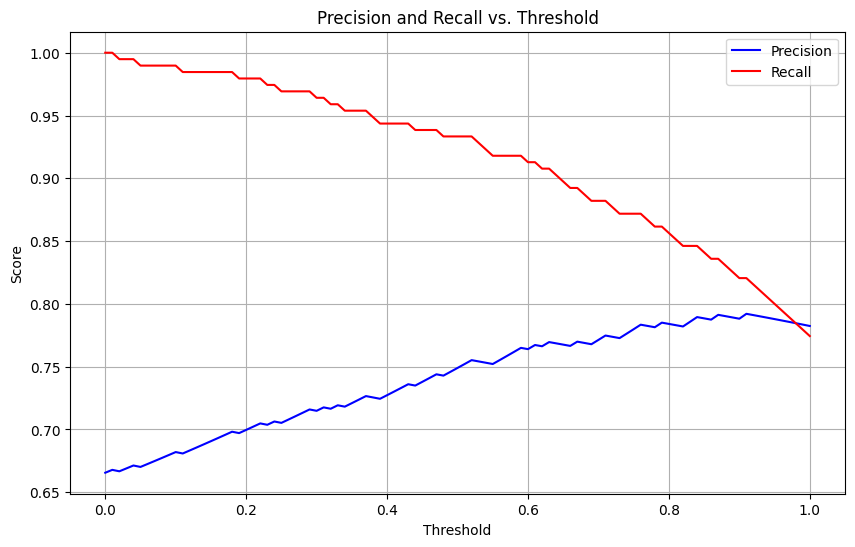

The precision and recall curves intersect at threshold: 0.980


In [18]:
# Plot Precision and Recall curves
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label="Precision", color='blue')
plt.plot(thresholds, recalls, label="Recall", color='red')
plt.title("Precision and Recall vs. Threshold")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()

# Find the threshold where precision and recall intersect
intersect_threshold = thresholds[np.argmin(np.abs(precisions - recalls))]
print(f"The precision and recall curves intersect at threshold: {intersect_threshold:.3f}")

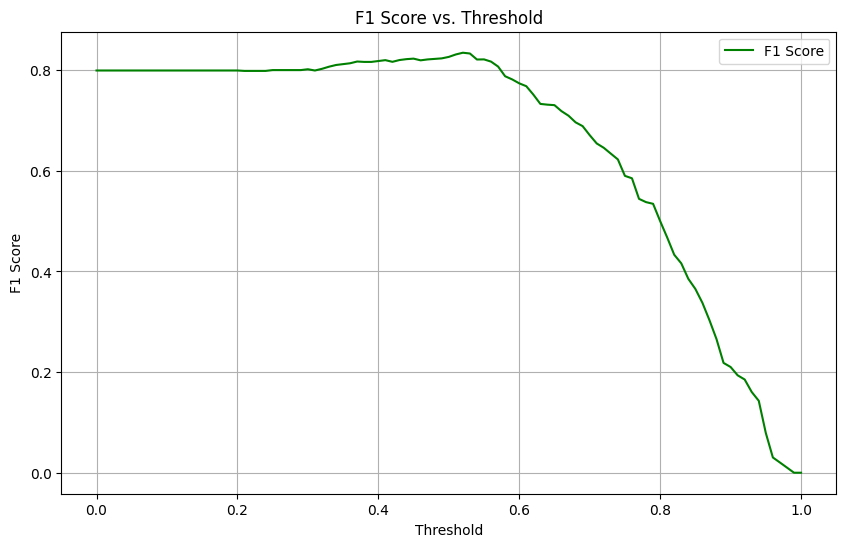

The threshold that maximizes the F1 score is: 0.520


In [19]:
from sklearn.metrics import f1_score

# Initialize list to store F1 scores for each threshold
f1_scores = []

# Calculate F1 score for each threshold
for threshold in thresholds:
    # Convert probabilities to binary predictions based on the threshold
    y_pred_threshold = (y_prob >= threshold).astype(int)

    # Compute F1 score
    f1 = f1_score(y_test, y_pred_threshold)

    # Store F1 score
    f1_scores.append(f1)

# Convert f1_scores to numpy array for easier plotting
f1_scores = np.array(f1_scores)

# Plot the F1 score vs. threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label="F1 Score", color='green')
plt.title("F1 Score vs. Threshold")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.grid(True)
plt.legend()
plt.show()

# Find the threshold where F1 is maximal
max_f1_threshold = thresholds[np.argmax(f1_scores)]
print(f"The threshold that maximizes the F1 score is: {max_f1_threshold:.3f}")


In [21]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import numpy as np

# Assuming df_full_train is already loaded
# We'll use df_train from earlier as df_full_train here for simplicity (replace with your actual data)
X = df[numerical_columns]  # Features (excluding target column)
y = df['converted']  # Target variable

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Initialize model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

# List to store AUC scores for each fold
auc_scores = []

# Iterate over KFold splits
for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Train the model
    model.fit(X_train, y_train)

    # Predict probabilities on the validation set
    y_prob = model.predict_proba(X_val)[:, 1]  # Probabilities for the positive class

    # Compute AUC score for this fold
    auc = roc_auc_score(y_val, y_prob)
    auc_scores.append(auc)

# Compute the standard deviation of AUC scores across folds
std_auc = np.std(auc_scores)

# Output the result
print(f"Standard deviation of AUC scores across folds: {std_auc:.4f}")


Standard deviation of AUC scores across folds: 0.0277


In [23]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import numpy as np

# Assuming df_train is loaded
X = df[numerical_columns]  # Features (excluding target column)
y = df['converted']  # Target variable

# Hyperparameter values for C
C_values = [0.000001, 0.001, 1]

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Initialize a dictionary to store the mean and std of AUC for each C
results = {}

# Iterate over different C values
for C in C_values:
    auc_scores = []

    # KFold cross-validation
    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Train the logistic regression model
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train, y_train)

        # Predict probabilities for the positive class
        y_prob = model.predict_proba(X_val)[:, 1]

        # Compute AUC score for the fold
        auc = roc_auc_score(y_val, y_prob)
        auc_scores.append(auc)

    # Calculate mean and std of AUC for this value of C
    mean_auc = np.mean(auc_scores)
    std_auc = np.std(auc_scores)

    # Store the results
    results[C] = {'mean': round(mean_auc, 3), 'std': round(std_auc, 3)}

# Output the results
print("AUC Results (mean and std) for each C value:")
for C, result in results.items():
    print(f"C={C}: Mean AUC = {result['mean']}, Std AUC = {result['std']}")

# Find the best C based on the criteria
best_C = min(results, key=lambda x: (results[x]['mean'], results[x]['std'], x))

print(f"\nBest C value: {best_C} (Mean AUC: {results[best_C]['mean']}, Std AUC: {results[best_C]['std']})")


AUC Results (mean and std) for each C value:
C=1e-06: Mean AUC = 0.549, Std AUC = 0.031
C=0.001: Mean AUC = 0.853, Std AUC = 0.025
C=1: Mean AUC = 0.807, Std AUC = 0.028

Best C value: 1e-06 (Mean AUC: 0.549, Std AUC: 0.031)
